# Introduction

Short notebook to get an overview of model performance across architectures and dimensionality.

Here we share some code to train a model from scratch and our procedure for evaluating and selecting models to study.

For each architecture (RNN, GRU, LSTM, NM-RNN) and dimensionality (1 or 2 hidden units) we fit a model to predict a subject's (WS16) choices during a 2-armed bandit task (75% reward probability at 'good poke' and 25% reward probability at the other poke). Note that in this data there are forced choice trials, but the loss associated with these predictions are excluded (since forced choices are random and cannot be predicted well).

All trials for a subject are split into train (80%), validation (10%), an evaluation (10%), seeded deterministically across models and repeated for 10 different seeds. 

Training is done with an early stop on validation prediction errors within each model type but across hyperparameters (varying sparsity). 

Then across models we compare performance on evaluation prediction errors. 

We then select the median performing model on the evaluation performance, so as not to overfit the transfer learning variability across splits.

We further study how these models predict the behaviour in the `mechanisms` notebook!

In [1]:
## setup on google colab:

!git clone https://github.com/charlesdgburns/NM_TinyRNN.git
from pathlib import Path
CODE_DIR = Path('.')
SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = './NM_TinyRNN/data/AB_behaviour/WS16'


fatal: destination path 'NM_TinyRNN' already exists and is not an empty directory.


In [1]:
# local setup 

#may need to change directory to import the below
CODE_DIR = Path(r'C:\Users\owner\Research\NM_TinyRNN') #the directory containing NM_TinyRNN folder

import os
os.chdir(CODE_DIR.parent)

# there's multiple openMP processes on my local, 
# the following is an unsafe, unsupported, undocumented, workaround:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


NameError: name 'Path' is not defined

In [3]:
# general setup:

import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt


from NM_TinyRNN.code.models import training
from NM_TinyRNN.code.models import datasets
from NM_TinyRNN.code.models import rnns
from NM_TinyRNN.code.models import parallelised_training as pat
from importlib import reload

CODE_DIR =Path('.') #the directory containing NM_TinyRNN folder

SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
DATA_PATH = CODE_DIR/'NM_TinyRNN/data/AB_behaviour/MA08'


### Model training

Here we leave a bit of code to show how we train models, first one-by-one and then with a parallelised training approach (on a SLURM managed computing cluster).

Starting training with 1 sparsity values...
Dataset size: 192
Split sizes - Train: 147, Validation: 24, Evaluation: 21

Training with  
 weight seed = 1,
 sparsity lambda = 1e-05, 
 energy lambda = 0.01, 
 hebbian lambda = None


λ=1e-05:  39%|███▉      | 3897/10000 [11:17<17:41,  5.75it/s]


Early stopping after 3898 epochs

Training with  
 weight seed = 2,
 sparsity lambda = 1e-05, 
 energy lambda = 0.01, 
 hebbian lambda = None


λ=1e-05:  53%|█████▎    | 5305/10000 [15:20<13:34,  5.77it/s]


Early stopping after 5306 epochs

Training with  
 weight seed = 3,
 sparsity lambda = 1e-05, 
 energy lambda = 0.01, 
 hebbian lambda = None


λ=1e-05:   3%|▎         | 313/10000 [00:54<28:02,  5.76it/s]


Early stopping after 314 epochs

Training with  
 weight seed = 4,
 sparsity lambda = 1e-05, 
 energy lambda = 0.01, 
 hebbian lambda = None


λ=1e-05:  29%|██▉       | 2934/10000 [08:28<20:24,  5.77it/s]


Early stopping after 2935 epochs

Training with  
 weight seed = 5,
 sparsity lambda = 1e-05, 
 energy lambda = 0.01, 
 hebbian lambda = None


λ=1e-05:   6%|▌         | 552/10000 [01:35<27:21,  5.75it/s]


Early stopping after 553 epochs

Evaluating best model (sparsity = 1e-05, energy = 0.01, weight_seed = 2) on test set...
Evaluation loss: 0.554194

Training complete!
Best model (λ=1e-05) saved to: NM_TinyRNN/data/rnns/test
Best validation loss: 0.554971
Test loss: 0.554194
Lastly, extracting activations on full dataset


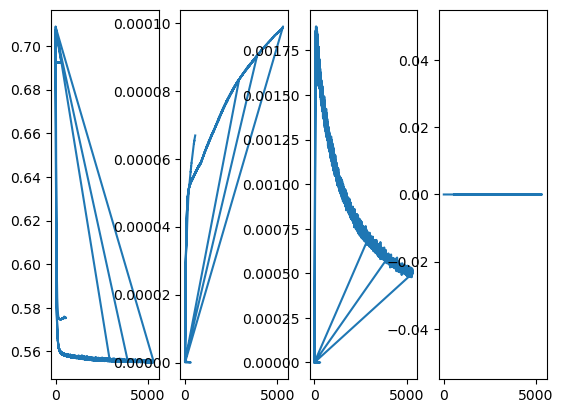

,hidden_1,hidden_2,gate_update_1,logit_value,logit_past,logit_change,prob_A,prob_b,forced_choice,choice,outcome,good_poke,session_trial_idx,sequence_block_idx,session_folder_name,trial_type,indices_train,indices_validation,indices_evaluation
0,0.000000,0.0,0.132031,-1.198026,NaN,NaN,0.231827,0.768173,0,1,0,1,0,0,2025-12-17-132938,"A2, R=0",True,False,False
1,0.119740,0.0,0.930733,-0.450934,-1.198026,0.747092,0.389139,0.610861,0,0,0,1,1,0,2025-12-17-132938,"A1, R=0",True,False,False
2,0.181880,0.0,0.940494,-0.063231,-0.450934,0.387703,0.484197,0.515803,0,0,0,1,2,0,2025-12-17-132938,"A1, R=0",True,False,False
3,0.072898,0.0,0.789689,-0.743197,-0.063231,-0.679966,0.322305,0.677695,1,1,1,1,3,0,2025-12-17-132938,"A2, R=1",True,False,False
4,0.062417,0.0,0.143772,-0.808589,-0.743197,-0.065392,0.308191,0.691809,0,1,0,1,4,0,2025-12-17-132938,"A2, R=0",True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,0.084202,0.0,0.794245,-0.672665,0.064066,-0.736730,0.337900,0.662100,0,1,1,1,163,191,2025-12-07-133319,"A2, R=1",False,False,False
4028,0.019631,0.0,0.766856,-1.075541,-0.672665,-0.402877,0.254351,0.745649,1,1,1,1,164,191,2025-12-07-133319,"A2, R=1",False,False,False
4029,0.004891,0.0,0.750844,-1.167508,-1.075541,-0.091967,0.237306,0.762694,0,1,1,1,165,191,2025-12-07-133319,"A2, R=1",False,False,False
4030,0.122306,0.0,0.931160,-0.434926,-1.167508,0.732583,0.392951,0.607049,0,0,0,1,166,191,2025-12-07-133319,"A1, R=0",False,False,False


In [45]:
# Train some models using the standard code
reload(training)
reload(datasets)
reload(rnns)


SEQUENCE_LENGTH = 20 # sequence length for batched training.

train_seed = 2
#weight_seed = 14

options_dict = {'rnn_type':'monoGRU',
                'input_size':3,
                'hidden_size':2,
                'nonlinearity':'relu',
                'input_encoding':'unipolar',
                'init_decoder':False}

dataset = datasets.AB_Dataset(DATA_PATH, SEQUENCE_LENGTH)
model = rnns.TinyRNN(**options_dict)  
trainer = training.Trainer(SAVE_PATH/'test',
                        batch_size = 8, 
                        max_epochs = 10000, 
                        early_stop = 290,
                        train_seed = train_seed,
                        sparsity_lambdas = [1e-5],
                        energy_lambdas = [1e-2],
                        hebbian_lambdas = [None], #interesting idea, doesn't work in practice. We would need to skip the ones with all 0 activity.
                        weight_seeds = [1,2,3,4,5], #[x for x in range(1,21)],# # [x for x in range(1,21)],# [x for x in range(1,21)],
                        learning_rate = 1e-3)

training_losses_df = trainer.fit(model,dataset)

# plot losses
fig, ax = plt.subplots(1,4)
ax[0].plot(training_losses_df.val_pred_losses)
ax[1].plot(training_losses_df.train_sparsity)
ax[2].plot(training_losses_df.train_energy)
ax[3].plot(training_losses_df.train_hebbian)
plt.show()  
# also get trials_df
trials_df = trainer.get_model_trial_by_trial_df(model,dataset)
trials_df

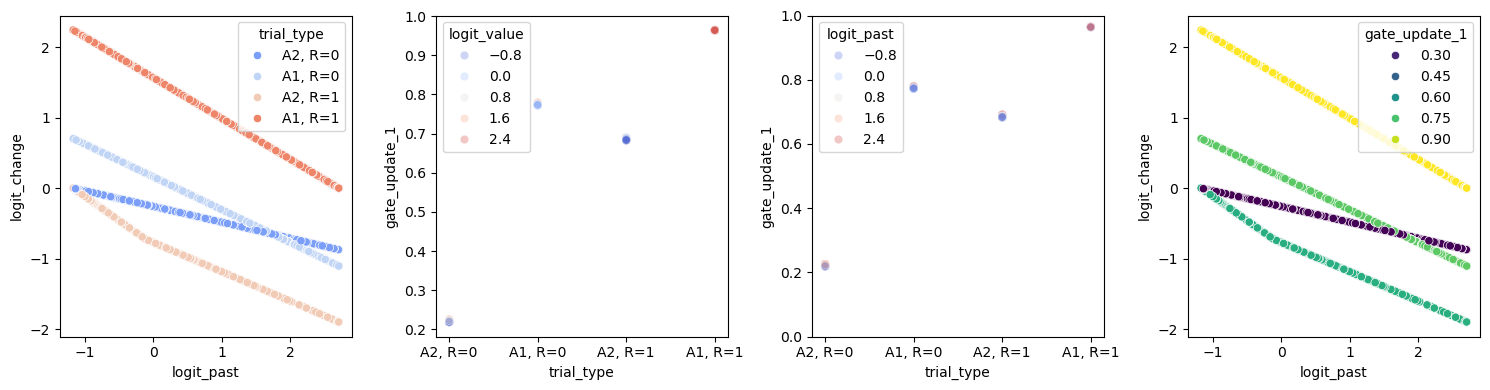

In [43]:
#trials_df = pd.read_csv('/ceph/behrens/wsilver/reversal/code/NM_TinyRNN/data/rnns/run_4_but10epoch/WS18/random_seed_2/monoGRU/energy/weight_seed_14/1_unit_monoGRU_relu_unipolar_trials_data.htsv', sep = '\t')
#trials_df = pd.read_csv('./NM_TinyRNN/data/rnns/run_4/WS18/random_seed_2/monoGRU/energy/weight_seed_17/1_unit_monoGRU_relu_unipolar_trials_data.htsv', sep = '\t')
#trials_df = pd.read_csv('/ceph/behrens/wsilver/reversal/code/NM_TinyRNN/data/rnns/run_4_but10epoch/WS18/random_seed_2/monoGRU/energy/weight_seed_14/1_unit_monoGRU_relu_unipolar_trials_data.htsv', sep='\t')
#trials_df = trainer.get_model_trial_by_trial_df(model,dataset)

fig, ax = plt.subplots(1,4, figsize = (15,4))
sns.scatterplot(trials_df,x='logit_past',y='logit_change', 
                hue = 'trial_type', palette='coolwarm', 
                ax= ax[0])
sns.scatterplot(trials_df, x='trial_type', y='gate_update_1', 
                hue = 'logit_value', palette='coolwarm', 
                ax = ax[1], alpha=0.3)
sns.scatterplot(trials_df, x='trial_type', y='gate_update_1', 
                hue = 'logit_past', palette='coolwarm', 
                ax = ax[2], alpha=0.3)
sns.scatterplot(trials_df, x='logit_past', y='logit_change', 
                hue = 'gate_update_1', palette='viridis', 
                ax = ax[3])
ax[2].set(ylim=(0,1))
fig.tight_layout()

<Axes: xlabel='hidden_1', ylabel='hidden_2'>

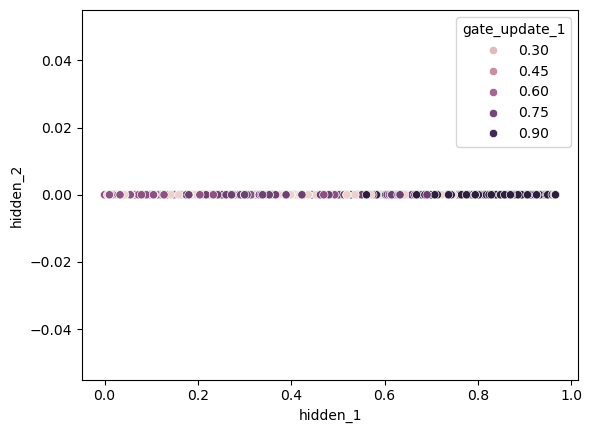

In [44]:
sns.scatterplot(trials_df, x= 'hidden_1',y='hidden_2', hue='gate_update_1')

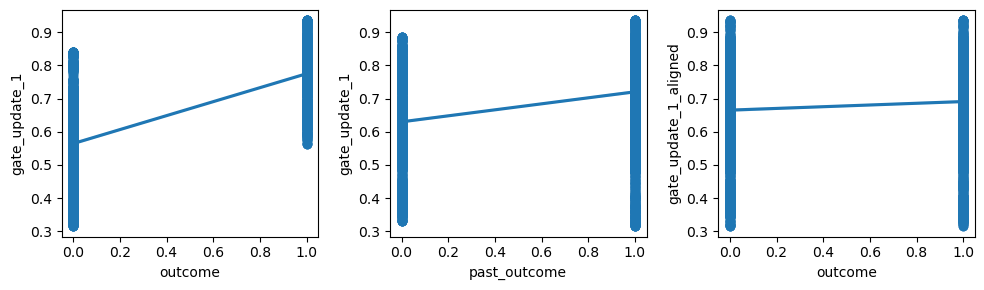

In [21]:
## adding a few columns to check for feature autocorrelation
trials_df = pd.read_csv('../code/NM_TinyRNN/data/rnns/subject_examples/WS08/monoGRU/2_unit_monoGRU_relu_unipolar_trials_data.htsv', 
                        sep = '\t')

trials_df['past_outcome'] = trials_df.shift(1)['outcome']
trials_df['gate_update_1_aligned'] = trials_df.shift(1)['gate_update_1']


fig, ax = plt.subplots(1,3, figsize=(10,3))
sns.regplot(trials_df,x='outcome',y='gate_update_1', 
            ax = ax[0])
sns.regplot(trials_df,x='past_outcome',y='gate_update_1', 
            ax = ax[1])
sns.regplot(trials_df,x='outcome',y='gate_update_1_aligned', 
            ax = ax[2])
fig.tight_layout()

In [15]:
trials_df

,hidden_1,hidden_2,gate_update_1,logit_value,logit_past,logit_change,prob_A,prob_b,forced_choice,choice,...,good_poke,session_trial_idx,sequence_block_idx,session_folder_name,trial_type,indices_train,indices_validation,indices_evaluation,past_outcome,gate_update_1_aligned
0,0.390627,0.234771,0.777361,0.814859,NaN,NaN,0.693144,0.306856,1,0,...,0,0,0,2024-05-16-155413,"A1, R=1",True,False,False,NaN,NaN
1,0.299124,0.094799,0.596206,0.892145,0.814859,0.077286,0.709333,0.290667,0,0,...,0,1,0,2024-05-16-155413,"A1, R=0",True,False,False,1.0,0.777361
2,0.564154,0.183982,0.780466,1.353392,0.892145,0.461247,0.794683,0.205316,0,0,...,0,2,0,2024-05-16-155413,"A1, R=1",True,False,False,0.0,0.596206
3,0.429201,0.079649,0.567079,1.246172,1.353392,-0.107219,0.776637,0.223363,0,0,...,0,3,0,2024-05-16-155413,"A1, R=0",True,False,False,1.0,0.780466
4,0.342520,0.036131,0.546376,1.126405,1.246172,-0.119767,0.755175,0.244825,1,0,...,0,4,0,2024-05-16-155413,"A1, R=0",True,False,False,0.0,0.567079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6186,0.117670,0.065810,0.596179,0.506873,0.309545,0.197328,0.624073,0.375927,0,0,...,1,297,40,2024-05-12-150919,"A1, R=0",False,False,False,0.0,0.697753
6187,0.119373,0.028461,0.567521,0.591991,0.506873,0.085118,0.643822,0.356178,1,0,...,1,298,40,2024-05-12-150919,"A1, R=0",False,False,False,0.0,0.596179
6188,0.043468,0.584682,0.635862,-0.800461,0.591991,-1.392451,0.309927,0.690073,0,1,...,1,299,40,2024-05-12-150919,"A2, R=1",False,False,False,0.0,0.567521
6189,0.019071,0.437573,0.561258,-0.542003,-0.800461,0.258457,0.367722,0.632278,0,1,...,1,300,40,2024-05-12-150919,"A2, R=0",False,False,False,1.0,0.635862


In [37]:
for name, param in model.named_parameters():
    print(name,param)

rnn.W_ih Parameter containing:
tensor([[ 0.5397,  0.5372],
        [-0.7185,  0.6403]], requires_grad=True)
rnn.W_hh Parameter containing:
tensor([[ 0.2748, -0.3342],
        [ 0.2003,  0.3259]], requires_grad=True)
rnn.W_iz Parameter containing:
tensor([[ 1.2821],
        [-0.3655]], requires_grad=True)
rnn.W_hz Parameter containing:
tensor([[-0.0312],
        [ 1.6831]], requires_grad=True)
rnn.bias_h Parameter containing:
tensor([-1.9031e-04, -5.7010e-01], requires_grad=True)
rnn.bias_z Parameter containing:
tensor([1.1673], requires_grad=True)
decoder.weight Parameter containing:
tensor([[ 1.3840, -0.3180],
        [-1.0090,  1.5544]], requires_grad=True)
decoder.bias Parameter containing:
tensor([ 0.0341, -0.0464], requires_grad=True)


ValueError: Could not interpret value `gate_update_2` for `y`. An entry with this name does not appear in `data`.

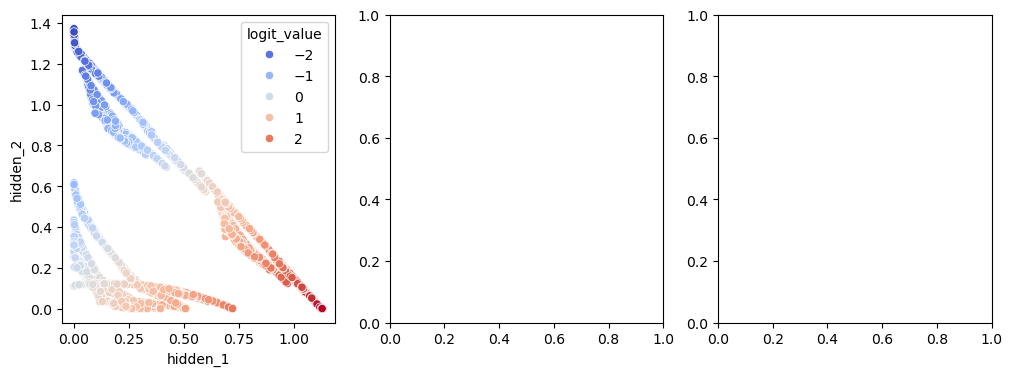

In [17]:
#Gru plots
fig, ax  = plt.subplots(1,3, figsize = (12,4))
sns.scatterplot(trials_df, x='hidden_1', y='hidden_2', 
                hue = 'logit_value', palette='coolwarm', 
                ax = ax[0])
sns.scatterplot(trials_df, x='gate_update_1', y='gate_update_2',
                hue='trial_type',ax = ax[1])
sns.scatterplot(trials_df, x='gate_reset_1', y='gate_reset_2',
                hue = 'logit_past',ax = ax[2])
ax[1].set(xlim=[0,1], ylim=[0,1])
ax[2].set(xlim=[0,1], ylim=[0,1])

In [49]:
for name, param in model.named_parameters():
    print(name, param)

rnn.W_from_in Parameter containing:
tensor([[ 1.2661, -0.6966, -0.7331,  1.6418, -0.2128, -0.3608],
        [-0.9525, -0.4386,  1.7084,  1.5276, -0.3568, -0.2663]],
       requires_grad=True)
rnn.W_from_h Parameter containing:
tensor([[-0.8472,  0.1981, -1.5807,  0.3492,  0.7527, -0.6579],
        [-0.9704, -0.9855,  1.6917,  1.4776,  0.1168,  0.7500]],
       requires_grad=True)
rnn.bias Parameter containing:
tensor([ 0.5017, -0.3257, -0.3141,  0.5724, -0.4183, -0.3234, -0.6424, -0.0806,
        -0.9974,  0.3023,  0.8432,  0.1602], requires_grad=True)
decoder.weight Parameter containing:
tensor([[ 3.2263, -1.7681],
        [-2.6490,  1.8356]], requires_grad=True)
decoder.bias Parameter containing:
tensor([-0.3549,  0.2713], requires_grad=True)


In [40]:
# you can train a bunch of models with pat:

reload(pat)
pat.run_training(overwrite=False) #OBS: this will send jobs ot the cluster !
#info_df = pat.get_DA_info_df()
#pat.get_DA_info_df().completed.mean()
#info_df.subject_ID.unique()
#pat.train_parallel(DATA_PATH,SAVE_PATH/'test', model_type = 'monoGRU')

Submitting model training for WS16 to HPC
Submitted batch job 2406993
All NM_TinyRNN jobs submitted to HPC. Check progress with 'squeue -u <username>'


In [41]:
train_df = pat.get_DA_info_df()

train_df[train_df.completed==False]

,subject_ID,train_seed,model_type,hidden_size,nonlinearity,input_encoding,constraint,nm_size,nm_dim,nm_mode,model_id,save_path,data_path,completed
588,WS16,8,monoGRU,1,relu,unipolar,energy,1,1,row,1_unit_monoGRU_relu_unipolar,NM_TinyRNN/data/rnns/run_DA_slow/WS16/random_s...,NM_TinyRNN/data/AB_behaviour/WS16,0


In [42]:
pat.get_DA_info_df()

,subject_ID,train_seed,model_type,hidden_size,nonlinearity,input_encoding,constraint,nm_size,nm_dim,nm_mode,model_id,save_path,data_path,completed
0,WS20,1,monoGRU,1,relu,unipolar,energy,1,1,row,1_unit_monoGRU_relu_unipolar,NM_TinyRNN/data/rnns/run_DA_slow/WS20/random_s...,NM_TinyRNN/data/AB_behaviour/WS20,1
1,WS20,1,monoGRU,2,relu,unipolar,energy,1,1,row,2_unit_monoGRU_relu_unipolar,NM_TinyRNN/data/rnns/run_DA_slow/WS20/random_s...,NM_TinyRNN/data/AB_behaviour/WS20,1
2,WS20,1,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_DA_slow/WS20/random_s...,NM_TinyRNN/data/AB_behaviour/WS20,1
3,WS20,1,GRU,2,tanh,unipolar,sparsity,1,1,row,2_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_DA_slow/WS20/random_s...,NM_TinyRNN/data/AB_behaviour/WS20,1
4,WS20,2,monoGRU,1,relu,unipolar,energy,1,1,row,1_unit_monoGRU_relu_unipolar,NM_TinyRNN/data/rnns/run_DA_slow/WS20/random_s...,NM_TinyRNN/data/AB_behaviour/WS20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,WS09,19,GRU,2,tanh,unipolar,sparsity,1,1,row,2_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_DA_slow/WS09/random_s...,NM_TinyRNN/data/AB_behaviour/WS09,1
956,WS09,20,monoGRU,1,relu,unipolar,energy,1,1,row,1_unit_monoGRU_relu_unipolar,NM_TinyRNN/data/rnns/run_DA_slow/WS09/random_s...,NM_TinyRNN/data/AB_behaviour/WS09,1
957,WS09,20,monoGRU,2,relu,unipolar,energy,1,1,row,2_unit_monoGRU_relu_unipolar,NM_TinyRNN/data/rnns/run_DA_slow/WS09/random_s...,NM_TinyRNN/data/AB_behaviour/WS09,1
958,WS09,20,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_DA_slow/WS09/random_s...,NM_TinyRNN/data/AB_behaviour/WS09,1


In [43]:
for subdir in Path('./NM_TinyRNN/data/AB_behaviour').iterdir():
    print(subdir)

NM_TinyRNN/data/AB_behaviour/WS20
NM_TinyRNN/data/AB_behaviour/WS14
NM_TinyRNN/data/AB_behaviour/WS08
NM_TinyRNN/data/AB_behaviour/README.md
NM_TinyRNN/data/AB_behaviour/WS01
NM_TinyRNN/data/AB_behaviour/WS18
NM_TinyRNN/data/AB_behaviour/WS13
NM_TinyRNN/data/AB_behaviour/WS22
NM_TinyRNN/data/AB_behaviour/WS16
NM_TinyRNN/data/AB_behaviour/WS02
NM_TinyRNN/data/AB_behaviour/WS05
NM_TinyRNN/data/AB_behaviour/WS10
NM_TinyRNN/data/AB_behaviour/WS09


### Model performance and selection

Models are trained on 80% training data, with early stopping on 10% validation data, before computing a performance score on the last 10% evaluation data.

We do this with 10 random seeds and select the median performing model, for each architecture, in order to avoid overfitting on the data splits.

These 'median' models are then investigated further.

In [41]:
!squeue -u cburns

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           2442657       cpu NM_TinyR   cburns CF       0:25      1 enc1-node11
           2442658       cpu NM_TinyR   cburns CF       0:25      1 enc2-node4
           2442659       cpu NM_TinyR   cburns CF       0:25      1 enc2-node5
           2442660       cpu NM_TinyR   cburns CF       0:25      1 enc2-node6
           2442648       cpu NM_TinyR   cburns CF       0:26      1 enc1-node2
           2442649       cpu NM_TinyR   cburns CF       0:26      1 enc1-node2
           2442650       cpu NM_TinyR   cburns CF       0:26      1 enc1-node4
           2442651       cpu NM_TinyR   cburns CF       0:26      1 enc1-node4
           2442652       cpu NM_TinyR   cburns CF       0:26      1 enc1-node8
           2442653       cpu NM_TinyR   cburns CF       0:26      1 enc1-node8
           2442654       cpu NM_TinyR   cburns CF       0:26      1 enc2-node2
           2442655       cpu NM_TinyR   cburn

In [5]:
reload(pat)
info_df = pat.get_MA_info_df()
#pat.run_training()
info_df.completed.mean()

np.float64(1.0)

In [6]:
# you've trained a bunch of models with pat
#Here we append the evaluation performance to the model info dataframe
reload(pat)
info_df = pat.get_MA_info_df()
evals = []
min_weights = []
seeds = []
for model_info in info_df.itertuples():
    
    model_dir = Path(model_info.save_path)
    weight_seed_val_losses = []
    weight_seed_eval_losses = []
    for weight_seed in range(1,6):
        # select the weight seed with the best validation performance
        eval_json_path = model_dir /f'weight_seed_{weight_seed}'/ f'{model_info.model_id}_info.json'

        if eval_json_path.exists():
            with open(eval_json_path, 'r') as f:
                eval_info = json.load(f)
            weight_seed_val_losses.append(eval_info['best_val_pred_loss'])
            weight_seed_eval_losses.append(eval_info['eval_pred_loss'])
        else:
            print(f'failed to find info json for {model_info.model_id} weight seed {weight_seed}\n ')
    
    if len(weight_seed_val_losses) == 0:
        evals.append(np.nan)
        min_weights.append(np.nan)
    else:
        min_idx = np.argmin(weight_seed_val_losses)
        min_weights.append(int(min_idx+1))
        evals.append(weight_seed_eval_losses[min_idx])
info_df['eval_CE'] = evals
info_df['best_weight_seed'] = min_weights
#open the json and extract eval performance for each model: 

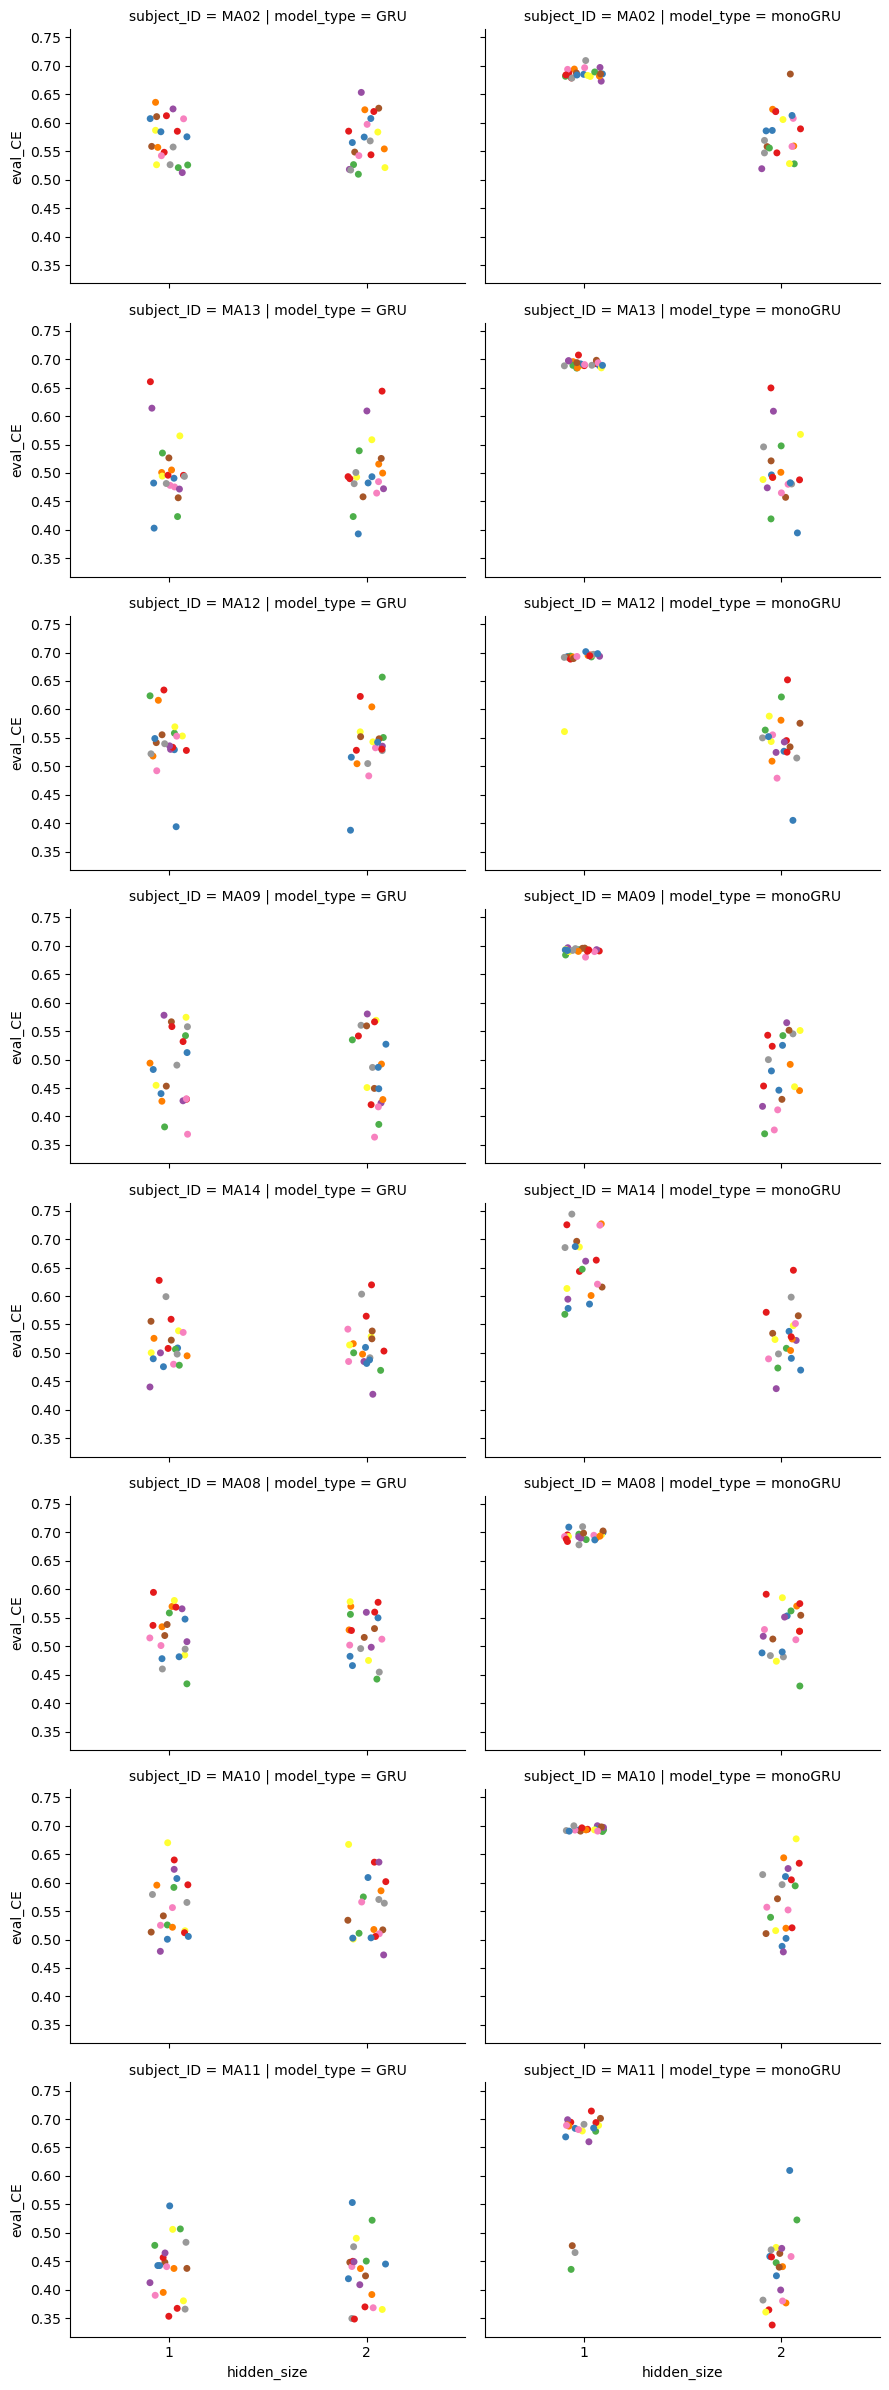

In [7]:
#Plot model performance across seeds and architectures:
filtered_df = pd.concat([info_df.query('model_type == "GRU" and constraint == "sparsity" and nonlinearity == "tanh"'),
                        info_df.query('model_type == "monoGRU" and constraint == "energy" and nonlinearity == "relu"')])
filtered_df['hidden_size'] = filtered_df['hidden_size'].astype(str)

g = sns.FacetGrid(filtered_df, row = 'subject_ID', col='model_type',  aspect = 1.5)

g.map_dataframe(sns.stripplot,x='hidden_size',y='eval_CE',
                hue='train_seed', palette="Set1",)


In [33]:
info_df.query('subject_ID == "WS16" and train_seed==1')

,subject_ID,train_seed,model_type,hidden_size,nonlinearity,input_encoding,constraint,nm_size,nm_dim,nm_mode,model_id,save_path,data_path,completed,eval_CE,best_weight_seed
160,WS16,1,monoGRU,1,relu,unipolar,energy,1,1,row,1_unit_monoGRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.500918,18.0
161,WS16,1,monoGRU,2,relu,unipolar,energy,1,1,row,2_unit_monoGRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.453174,1.0
162,WS16,1,monoGRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_monoGRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.468895,17.0
163,WS16,1,monoGRU,2,tanh,unipolar,sparsity,1,1,row,2_unit_monoGRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.464640,14.0
164,WS16,1,GRU,1,relu,unipolar,energy,1,1,row,1_unit_GRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.463278,20.0
165,WS16,1,GRU,2,relu,unipolar,energy,1,1,row,2_unit_GRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.452346,18.0
166,WS16,1,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.459779,12.0
167,WS16,1,GRU,2,tanh,unipolar,sparsity,1,1,row,2_unit_GRU,NM_TinyRNN/data/rnns/run_4/WS16/random_seed_1/...,NM_TinyRNN/data/AB_behaviour/WS16,False,0.456036,4.0


In [99]:
info_df.columns

Index(['subject_ID', 'train_seed', 'model_type', 'hidden_size', 'nonlinearity',
       'input_encoding', 'constraint', 'nm_size', 'nm_dim', 'nm_mode',
       'model_id', 'save_path', 'data_path', 'completed', 'eval_CE',
       'best_weight_seed'],
      dtype='object')

In [8]:
def closest_to_median(subdf):
    med = subdf["eval_CE"].median()
    idx = (subdf["eval_CE"] - med).abs().idxmin()
    return subdf.loc[idx, :]

median_df = info_df.query('completed==1').groupby(["model_id","subject_ID"]).apply(closest_to_median).reset_index(drop=True)
median_df

/tmp/ipykernel_951992/1906305871.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_df = info_df.query('completed==1').groupby(["model_id","subject_ID"]).apply(closest_to_median).reset_index(drop=True)


,subject_ID,train_seed,model_type,hidden_size,nonlinearity,input_encoding,constraint,nm_size,nm_dim,nm_mode,model_id,save_path,data_path,completed,eval_CE,best_weight_seed
0,MA02,7,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_MA_fast/MA02/random_s...,NM_TinyRNN/data/AB_behaviour/MA02,1,0.558536,4
1,MA08,5,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_MA_fast/MA08/random_s...,NM_TinyRNN/data/AB_behaviour/MA08,1,0.534175,4
2,MA09,18,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_MA_fast/MA09/random_s...,NM_TinyRNN/data/AB_behaviour/MA09,1,0.490274,4
3,MA10,17,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_MA_fast/MA10/random_s...,NM_TinyRNN/data/AB_behaviour/MA10,1,0.556112,2
4,MA11,2,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_MA_fast/MA11/random_s...,NM_TinyRNN/data/AB_behaviour/MA11,1,0.442448,1
5,MA12,18,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_MA_fast/MA12/random_s...,NM_TinyRNN/data/AB_behaviour/MA12,1,0.539677,1
6,MA13,6,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_MA_fast/MA13/random_s...,NM_TinyRNN/data/AB_behaviour/MA13,1,0.494585,5
7,MA14,3,GRU,1,tanh,unipolar,sparsity,1,1,row,1_unit_GRU_tanh_unipolar,NM_TinyRNN/data/rnns/run_MA_fast/MA14/random_s...,NM_TinyRNN/data/AB_behaviour/MA14,1,0.506383,3
8,MA02,2,monoGRU,1,relu,unipolar,energy,1,1,row,1_unit_monoGRU_relu_unipolar,NM_TinyRNN/data/rnns/run_MA_fast/MA02/random_s...,NM_TinyRNN/data/AB_behaviour/MA02,1,0.685183,1
9,MA08,14,monoGRU,1,relu,unipolar,energy,1,1,row,1_unit_monoGRU_relu_unipolar,NM_TinyRNN/data/rnns/run_MA_fast/MA08/random_s...,NM_TinyRNN/data/AB_behaviour/MA08,1,0.693389,3


In [9]:
## Code to get 'median_df' and copy over the median-performing models for testing and comparisons

def closest_to_median(subdf):
    med = subdf["eval_CE"].median()
    idx = (subdf["eval_CE"] - med).abs().idxmin()
    return subdf.loc[idx, :]

median_df = info_df.query('completed==1').groupby(["model_id","subject_ID"]).apply(closest_to_median).reset_index(drop=True)
median_df

def idx_min(subdf):
    min = subdf["eval_CE"].min()
    idx = (subdf["eval_CE"] - min).abs().idxmin()
    return subdf.loc[idx, :]

min_df = info_df.groupby("model_id").apply(idx_min).reset_index(drop=True)

import os
import shutil
from pathlib import Path

def copy_median_models(df, example_path):
    """
    Copy median performing model files into EXAMPLE_PATH/<model_type>/.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['save_path', 'model_type', 'model_ID'].
        save_path should be a pathlib.Path pointing to the model directory.
    example_path : str or Path
        Parent directory where copies will be stored.
    """
    example_path = Path(example_path)
    example_path.mkdir(parents=True, exist_ok=True)

    # files we want to copy for each model
    file_suffixes = [
        "_info.json",
        "_model_state.pth",
        "_training_losses.htsv",
        "_trials_data.htsv",
    ]
    
    for _, row in df.iterrows():
        save_path = Path(row["save_path"])
        model_type = row["model_type"]
        model_id = row["model_id"]
        subject_ID = row["subject_ID"]
        

        # make sure destination subfolder exists
        dest_dir = example_path /subject_ID/ model_type
        dest_dir.mkdir(parents=True, exist_ok=True)

        for suffix in file_suffixes:
            src = save_path / f"weight_seed_{int(row['best_weight_seed'])}/{model_id}{suffix}"
            dst = dest_dir / f"{model_id}{suffix}"
            if src.exists():
                shutil.copy(src, dst)
                print(f"Copied {src} → {dst}")
            else:
                print(f"Warning: {src} not found!")

# Example usage:
copy_median_models(median_df, Path('./NM_TinyRNN/data/rnns/subject_examples_MA'))


/tmp/ipykernel_951992/44437433.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_df = info_df.query('completed==1').groupby(["model_id","subject_ID"]).apply(closest_to_median).reset_index(drop=True)
/tmp/ipykernel_951992/44437433.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_df = info_df.groupby("model_id").apply(idx_min).reset_index(drop=True)


Copied NM_TinyRNN/data/rnns/run_MA_fast/MA02/random_seed_7/GRU/sparsity/weight_seed_4/1_unit_GRU_tanh_unipolar_info.json → NM_TinyRNN/data/rnns/subject_examples_MA/MA02/GRU/1_unit_GRU_tanh_unipolar_info.json
Copied NM_TinyRNN/data/rnns/run_MA_fast/MA02/random_seed_7/GRU/sparsity/weight_seed_4/1_unit_GRU_tanh_unipolar_model_state.pth → NM_TinyRNN/data/rnns/subject_examples_MA/MA02/GRU/1_unit_GRU_tanh_unipolar_model_state.pth
Copied NM_TinyRNN/data/rnns/run_MA_fast/MA02/random_seed_7/GRU/sparsity/weight_seed_4/1_unit_GRU_tanh_unipolar_training_losses.htsv → NM_TinyRNN/data/rnns/subject_examples_MA/MA02/GRU/1_unit_GRU_tanh_unipolar_training_losses.htsv
Copied NM_TinyRNN/data/rnns/run_MA_fast/MA02/random_seed_7/GRU/sparsity/weight_seed_4/1_unit_GRU_tanh_unipolar_trials_data.htsv → NM_TinyRNN/data/rnns/subject_examples_MA/MA02/GRU/1_unit_GRU_tanh_unipolar_trials_data.htsv
Copied NM_TinyRNN/data/rnns/run_MA_fast/MA08/random_seed_5/GRU/sparsity/weight_seed_4/1_unit_GRU_tanh_unipolar_info.json

# Development

We're keen on aligning training with e-prop style learning.

This means considering backprop after every trial.

In [ ]:
## writing code on the trainer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import json
from typing import List, Optional, Tuple, Dict, Any
from copy import deepcopy

from pathlib import Path

#Function to train a model on a subject's data

#Trainer class
TRAIN_SEED = 42 #fix the seed for splits and dataloading
# Set seeds for reproducibility
torch.manual_seed(TRAIN_SEED)
np.random.seed(TRAIN_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(TRAIN_SEED)

# utility that might be helpful elsewhere:
# we name our models consistently as follows:



## main class ##

class Trainer:
    def __init__(
        self,
        save_path: Path,
        weight_seeds: List[float] = [1,2,3,4,5], #[1,2,3,4,5,6,7,8,9,10],
        sparsity_lambdas: List[float] = [1e-5], #[1e-1,1e-3,1e-5],
        energy_lambdas: List[float] = [1e-2],
        hebbian_lambdas: List[float] = [None],
        learning_rate: float = 1e-2, #1e-4,#0.005,
        batch_size: int = 8,
        max_epochs: int = 100,
        early_stop: int = 20,
        train_seed: int = TRAIN_SEED,
        TBPTT: int = 0,
        save_gradients: bool = False,
    ):
        """
        Simple and concise trainer for neural networks with hyperparameter tuning.
        
        Args:
            save_path: Directory to save model and results
            sparsity_lambdas: List of sparsity regularization values to try. Outputs best model among them.
            learning_rate: Learning rate for Adam optimizer
            batch_size: Batch size for training
            max_epochs: Maximum number of training epochs
            early_stop: Number of epochs without validation improvement before stopping
            seed: Random seed for reproducibility
        """
        self.save_path = Path(save_path) #ensure it's a Path object
        self.sparsity_lambdas = sparsity_lambdas
        self.energy_lambdas = energy_lambdas
        self.hebbian_lambdas = hebbian_lambdas
        self.weight_seeds = weight_seeds
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.early_stop = early_stop
        self.train_seed = train_seed
        
        # Create save directory
        os.makedirs(save_path, exist_ok=True)
        
    def fit(self, model, dataset) -> pd.DataFrame:
        """
        Fit the model with hyperparameter tuning.
        
        Args:
            model: PyTorch model to train
            dataset: PyTorch dataset
            
        Returns:
            training_losses_df: DataFrame with training history for each sparsity value
        """
        print(f"Starting training with {len(self.sparsity_lambdas)} sparsity values...")
        print(f"Dataset size: {len(dataset)}")
        self.save_path.mkdir(parents=True,exist_ok=True)
        # Split dataset
        train_dataset, val_dataset, test_dataset,_ = self._split_dataset(dataset)
        print(f"Split sizes - Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Evaluation: {len(test_dataset)}")
        
        # Create dataloaders
        train_loader = self._create_dataloader(train_dataset, shuffle=True)
        val_loader = self._create_dataloader(val_dataset, shuffle=False)
        test_loader = self._create_dataloader(test_dataset, shuffle=False)
        
        # Store all results
        all_results = []
        best_overall_val_loss = float('inf')
        best_model_info = None
        
        ## TRAINING ##
        for sparsity_lambda in self.sparsity_lambdas:
            for energy_lambda in self.energy_lambdas:
                for hebbian_lambda in self.hebbian_lambdas:
                    for weight_seed in self.weight_seeds:
                        print(f"\nTraining with  \n weight seed = {weight_seed},\n sparsity lambda = {sparsity_lambda}, \n energy lambda = {energy_lambda}, \n hebbian lambda = {hebbian_lambda}")
                        # Reset model to initial state for each set of values
                        model.sparsity_lambda = sparsity_lambda 
                        model.energy_lambda = energy_lambda
                        model.hebbian_lambda = hebbian_lambda
                        model.weight_seed = weight_seed
                        model.init_weights() #reset model weights before training.
                    
                        losses_dict, best_model_dict = self._train_single_model(
                            model, train_loader, val_loader)
                        #append all the hyperparameters for each run
                        n_epochs = len(losses_dict['train_prediction'])
                        losses_dict['sparsity_lambda'] = np.repeat(sparsity_lambda,n_epochs )
                        losses_dict['energy_lambda'] = np.repeat(energy_lambda, n_epochs)
                        losses_dict['hebbian_lambda'] = np.repeat(hebbian_lambda, n_epochs)
                        losses_dict['weight_seed'] = np.repeat(weight_seed,n_epochs)
                        losses_dict['epoch'] = np.arange(1,n_epochs+1)
                        
                        all_results.append(losses_dict)
                        
                        # Track best model across all sparsity values
                        if best_model_dict['val_pred_loss'] < best_overall_val_loss:
                            best_overall_val_loss = best_model_dict['val_pred_loss']
                            best_model_info = {
                                'sparsity_lambda': sparsity_lambda,
                                'energy_lambda': energy_lambda,
                                'hebbian_lambda':hebbian_lambda,
                                'weight_seed': weight_seed,
                                'val_pred_loss': best_model_dict['val_pred_loss'],
                                'epochs_trained':best_model_dict['epochs_trained'],
                                'model_state': best_model_dict['model_state']
                            }
                        # catch nan values
                        if best_model_info is None:
                            best_model_info = {
                                'sparsity_lambda': sparsity_lambda,
                                'energy_lambda': energy_lambda,
                                'hebbian_lambda':hebbian_lambda,
                                'weight_seed': weight_seed,
                                'val_pred_loss': best_model_dict['val_pred_loss'],
                                'epochs_trained':best_model_dict['epochs_trained'],
                                'model_state': best_model_dict['model_state']
                            }
                    
                
        ## EVAL AND SAVING ##
        # Generate model ID for saving data:
        model_id = model.get_model_id()
        torch.save(best_model_info['model_state'],self.save_path/f'{model_id}_model_state.pth')
        
        # Evaluate on test set using run_epoch // we only really care about prediction cross-entropy
        print(f"\nEvaluating best model (sparsity = {best_model_info['sparsity_lambda']:.0e}, energy = {best_model_info['energy_lambda']}, weight_seed = {best_model_info['weight_seed']}) on test set...")
        model.load_state_dict(best_model_info['model_state'])
        #need to set hyperparameters for generating the correct options_dict further down
        model.sparsity_lambda = best_model_info['sparsity_lambda'] 
        model.energy_lambda = best_model_info['energy_lambda']
        model.hebbian_lambda = best_model_info['hebbian_lambda']
        model.weight_seed = best_model_info['weight_seed']
        model.eval()
        eval_losses = self._run_epoch(model, test_loader, None, 
                                            training=False)
        best_model_info['eval_pred_loss'] = eval_losses['prediction']
        print(f"Evaluation loss: {eval_losses['prediction']:.6f}")
        
        # Save model info
        model_info = self.__dict__.copy()
        model_info['model_id'] = model_id
        model_info['save_path'] = str(model_info['save_path']) #fix possible posix path issues
        model_info['best_val_pred_loss'] = best_model_info['val_pred_loss']
        model_info['epochs_trained'] = best_model_info['epochs_trained']
        model_info['eval_pred_loss'] = best_model_info['eval_pred_loss']
        model_info['options_dict'] = model.get_options_dict()
        with open(os.path.join(self.save_path, f'{model_id}_info.json'), 'w') as f:
            json.dump(model_info, f, indent=2)
        
        # Create training losses DataFrame
        training_losses_df = pd.concat([pd.DataFrame(x) for x in all_results if type(x) is dict])
        
        # Save training history
        losses_path = os.path.join(self.save_path, f'{model_id}_training_losses.htsv')
        training_losses_df.to_csv(losses_path, sep='\t', index=False)
        
        print(f"\nTraining complete!")
        print(f"Best model (λ={best_model_info['sparsity_lambda']:.0e}) saved to: {self.save_path}")
        print(f"Best validation loss: {best_model_info['val_pred_loss']:.6f}")
        print(f"Test loss: {best_model_info['eval_pred_loss']:.6f}")
        
        print(f"Lastly, extracting activations on full dataset")
        trial_by_trial_df = self.get_model_trial_by_trial_df(model,dataset)
        trial_by_trial_df.to_csv(self.save_path/f'{model_id}_trials_data.htsv', sep = '\t', index=False)
        return training_losses_df
    
    def _split_dataset(self, dataset) -> Tuple[Subset, Subset, Subset]:
        """Split dataset into train/val/test (80/10/10) respecting session folders."""
    
        # Get unique folders and shuffle them
        unique_folders = dataset.subject_df['session_folder_name'].unique()
        np.random.seed(self.train_seed)
        np.random.shuffle(unique_folders)
        
        # Calculate split points
        n_folders = len(unique_folders)
        train_end = int(0.8 * n_folders)
        val_size = max(1, round(0.1 * n_folders))
        
        # Assign folders to splits
        train_folders = unique_folders[:train_end]
        val_folders = unique_folders[train_end:train_end + val_size]
        test_folders = unique_folders[train_end + val_size:]
        
        folder_name2idx = dataset.subject_df.groupby('session_folder_name')['sequence_block_idx'].unique()

        indices_dict = {}
        indices_dict['indices_train'] = np.concat([folder_name2idx[x] for x in train_folders])
        indices_dict['indices_validation'] = np.concat([folder_name2idx[x] for x in val_folders])
        indices_dict['indices_evaluation'] = np.concat([folder_name2idx[x] for x in test_folders])

        train_dataset = Subset(dataset, indices_dict['indices_train'])
        val_dataset = Subset(dataset, indices_dict['indices_validation'])
        test_dataset = Subset(dataset, indices_dict['indices_evaluation'])
      
        return train_dataset, val_dataset, test_dataset, indices_dict
    
    def _create_dataloader(self, dataset, shuffle: bool = True) -> DataLoader:
        """Create dataloader with deterministic shuffling."""
        generator = torch.Generator()
        generator.manual_seed(self.train_seed)
        
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            generator=generator if shuffle else None
        )
    
    def _run_epoch(
        self,
        model,
        dataloader: DataLoader,
        optimizer=None,
        training: bool = True
    ) -> Tuple[float, float]:
        """
        Run a single epoch on the given dataloader.
        
        Args:
            model: PyTorch model
            dataloader: DataLoader to iterate over
            optimizer: Optimizer for training (None for evaluation)
            sparsity_lambda: Sparsity regularization weight
            training: Whether this is a training epoch
            
        Returns:
           epoch_losses: dictionary with loss type as keys and avg loss as value
        """
        if training:
            model.train()
        else:
            model.eval()
        
        epoch_losses = {}
        
        context_manager = torch.no_grad() if not training else torch.enable_grad()
        with context_manager:
            for batch_inputs, batch_targets in dataloader:
                B, S, _ = batch_inputs.shape
                if training and optimizer is not None:
                    optimizer.zero_grad()
                predictions, hidden_states = model(batch_inputs)
                # remove the free choice trials from the loss!
                free_choice = (batch_inputs[:,:,0]==0)#this should be a bool size (n_batch, n_seq)
                #displace by one index, since forced choice input at t means prediction for t-1 is impossible.
                free_choice[:,:-1] = free_choice[:,1:].clone() 
                free_choice = free_choice.flatten()
                masked_pred = predictions.reshape(B*S,model.O)[free_choice]
                masked_targets = batch_targets.reshape(B*S,model.O)[free_choice]
                losses =  model.compute_losses(masked_pred,masked_targets, hidden_states)
                
                if training and optimizer is not None:
                    loss = sum([x for x in losses.values()])
                    loss.backward()
                    optimizer.step()
               #store losses for later plotting
                for loss_type, loss_value in losses.items():
                    if len(epoch_losses)<len(losses):#first epoch needs initialisation
                        epoch_losses[loss_type]= 0
                    epoch_losses[loss_type]+=(loss_value.item())/len(dataloader) #division to get mean
                
        return epoch_losses
    
    def _train_single_model(
        self,
        model,
        train_loader: DataLoader,
        val_loader: DataLoader
    ) -> Tuple[Dict[str, Any], float]:
        """
        Train a single model with given sparsity lambda.
        
        Returns:
            losses_dict: Dictionary containing training history
            best_val_loss: Best validation loss achieved
        """
        # Clone model to avoid modifying original
        model_copy = deepcopy(model)
        model_copy.load_state_dict(model.state_dict())
        
        optimizer = torch.optim.AdamW(model_copy.parameters(), 
                                      lr=self.learning_rate,
                                      weight_decay = 0.0)
        
        # Training history
        losses_dict={}
        best_model_dict = {}

        best_val_pred_loss = float('inf')
        epochs_without_improvement = 0
        best_model_state = None
        
        for epoch in tqdm(range(self.max_epochs), desc=f"λ={model.sparsity_lambda:.0e}"):
            # Training epoch
            train_losses = self._run_epoch(
                model_copy, train_loader, optimizer, training=True)
            
            # Validation epoch // here we only care about cross-entropy of predictions
            validation_losses = self._run_epoch(model_copy, val_loader, None, 
                                           training=False)
            
            # Store losses
            for loss_type, loss_value in train_losses.items():
                if len(losses_dict) <= len(train_losses): #instantiate the first lists
                    losses_dict[f'train_{loss_type}']=[]
                    losses_dict['val_pred_losses'] = [] #instantiate this here also
                losses_dict[f'train_{loss_type}'].append(loss_value)
            losses_dict['val_pred_losses'].append(validation_losses['prediction'])    
            # Early stopping check
            if validation_losses['prediction'] < best_val_pred_loss:
                best_val_pred_loss = validation_losses['prediction']
                epochs_without_improvement = 0
                best_model_state = model_copy.to('cpu').state_dict().copy()
            else:
                epochs_without_improvement += 1
            
            if epochs_without_improvement >= self.early_stop:
                print(f"Early stopping after {epoch + 1} epochs")
                break
            
            if np.isnan(train_losses['hebbian']) or np.isnan(validation_losses['prediction']):
                print('NaN hebbian loss, skipping training')
                best_val_pred_loss = np.nan
                epochs_without_improvement = np.nan
                best_model_state = model_copy.to('cpu').state_dict().copy()
                break

        # Store further training history
        best_model_dict['epochs_trained'] = epoch+1
        best_model_dict['val_pred_loss'] = best_val_pred_loss
        best_model_dict['model_state'] = best_model_state

        return losses_dict, best_model_dict
    
    def get_model_trial_by_trial_df(self, model, dataset):
        '''Runs through the entire dataset (also training data)'''
        model.eval()
        trial_by_trial_data = {}
        inputs_reshaped = dataset.subject_df[['forced_choice','outcome','choice']].values[None,:,:]
        inputs_reshaped = torch.tensor(inputs_reshaped,dtype = torch.float32)
        with torch.no_grad():
            predictions, _ = model(inputs_reshaped)  
            if not model.rnn_type == 'vanilla': 
                if not model.input_forced_choice:
                    inputs_reshaped = inputs_reshaped[:,:,1:]
                if model.input_encoding == 'bipolar':
                    inputs_reshaped = inputs_reshaped*2-1 #maps 0 to -1 and 1 to 1.
                hidden_state, gate_activations = model.rnn(inputs_reshaped, return_gate_activations = True)
                # add hidden activations
                for each_unit in range(model.H):
                    trial_by_trial_data[f'hidden_{each_unit+1}'] = hidden_state[:,:,each_unit].flatten()
                # add gate activations
                for gate_label, activations in gate_activations.items():    
                    for each_unit in range(activations.shape[-1]):
                        trial_by_trial_data[f'gate_{gate_label}_{each_unit+1}'] = activations[:,:,each_unit].flatten()
        
        # add logit and probabilities data:
        log_probs= predictions.log_softmax(dim=2)
        logits = (log_probs[:,:,0] - log_probs[:,:,1]).flatten() #subtraction in log space is division before log.
        trial_by_trial_data['logit_value'] = logits
        trial_by_trial_data['logit_past'] = torch.cat([torch.tensor([torch.nan]),logits[:-1]])
        trial_by_trial_data['logit_change'] = torch.cat([torch.tensor([torch.nan]),(logits[1:]-logits[:-1])])
        trial_by_trial_data['prob_A'] = torch.exp(log_probs[:,:,0]).flatten()
        trial_by_trial_data['prob_b'] = torch.exp(log_probs[:,:,1]).flatten()
        #add actual trial data and whether trial was used in training, validation, or evaluation
        for column in dataset.subject_df.columns: 
            trial_by_trial_data[column] = dataset.subject_df.loc[:,column].values
        #add trial type as well for easy plotting later.
        labels = ['A1, R=0','A1, R=1', 'A2, R=0', 'A2, R=1']
        trial_type = trial_by_trial_data['choice']*2 + trial_by_trial_data['outcome']
        trial_by_trial_data['trial_type'] = [labels[i] for i in trial_type]
        
        _,_,_, indices_dict = self._split_dataset(dataset)
        for idx_label, idx_values in indices_dict.items():
            # Generate all trial indices for the given batches
            n_seq = dataset.inputs.shape[1] #(n_batch, n_seq, n_features) 
            n_trials = len(dataset.subject_df)
            trial_indices = np.concatenate([np.arange(idx * n_seq, (idx + 1) * n_seq) 
                                            for idx in idx_values])
            # Create boolean mask using isin
            all_trial_indices = np.arange(n_trials)
            label_indices = np.isin(all_trial_indices, trial_indices)
            indices_dict[idx_label] = label_indices
        trial_by_trial_data.update(indices_dict)
        #and what session folder to save to
        trial_by_trial_data['session_folder_name'] = dataset.session_folder_name[:n_trials]
        df = pd.DataFrame(trial_by_trial_data)
        return df

In [1]:
## we want to run a epoch with per-trial gradients

## setup:
SEQUENCE_LENGTH = 20 # sequence length for batched training.
train_seed = 11
options_dict = {'rnn_type':'monoGRU',
                'input_size':3,
                'hidden_size':2,
                'nonlinearity':'relu',
                'input_encoding':'unipolar',
                'init_decoder':False}
dataset = datasets.AB_Dataset(DATA_PATH, SEQUENCE_LENGTH)
model = rnns.TinyRNN(**options_dict)  

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=1e-2, 
                              weight_decay = 0.0)
dataloader  = DataLoader(dataset, batch_size=8, 
                         shuffle=True, 
                         generator=torch.Generator().manual_seed(train_seed))

training = True

## def_run_epoch()
if training:
    model.train()
else:
    model.eval()

epoch_losses = {}

context_manager = torch.no_grad() if not training else torch.enable_grad()
with context_manager:
    for batch_inputs, batch_targets in dataloader:
        B, S, _ = batch_inputs.shape
        if training and optimizer is not None:
            optimizer.zero_grad()
        predictions, hidden_states = model(batch_inputs)
        # remove the free choice trials from the loss!
        free_choice = (batch_inputs[:,:,0]==0)#this should be a bool size (n_batch, n_seq)
        #displace by one index, since forced choice input at t means prediction for t-1 is impossible.
        free_choice[:,:-1] = free_choice[:,1:].clone() 
        free_choice = free_choice.flatten()
        masked_pred = predictions.reshape(B*S,model.O)[free_choice]
        masked_targets = batch_targets.reshape(B*S,model.O)[free_choice]
        losses =  model.compute_losses(masked_pred,masked_targets, hidden_states)
        
        if training and optimizer is not None:
            loss = sum([x for x in losses.values()])
            loss.backward()
            optimizer.step()
        #store losses for later plotting
        for loss_type, loss_value in losses.items():
            if len(epoch_losses)<len(losses):#first epoch needs initialisation
                epoch_losses[loss_type]= 0
            epoch_losses[loss_type]+=(loss_value.item())/len(dataloader) #division to get mean
        

NameError: name 'datasets' is not defined

In [ ]:
epoch_losses